This project is greatly inspired by the following article:

[Building a full-text search engine in 150 lines of Python code](https://bart.degoe.de/building-a-full-text-search-engine-150-lines-of-code/)

and the Information Retrieval and Web Search lectures at the University of Mannheim, Germany

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! pip install datasets
# ! pip install nltk
# ! pip install tqdm

In [3]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from search import bool_rtrvl, phrase_rtrvl, vsm, bim, bim_ext, query_lklh, tf, idf, unigram, searching
from saveload import save_load
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd

[nltk_data] Downloading package words to
[nltk_data]     /home/georges_sarr/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/georges_sarr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/georges_sarr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 6.79 s, sys: 4.35 s, total: 11.1 s
Wall time: 3.96 s


# Indexing the documents collection

In [4]:
%%time
# inverted_index_sortpost,inverted_index_unsortpost,positional_index_sortpost,positional_index_unsortpost,term_freqs_log,\
# term_freqs_raw, doc_freqs, unigram=save_load(dataset="ms_marco", save=True, save_path="./data")
inverted_index_sortpost=save_load(dataset="ms_marco", save=True, save_path="./data")

.....................Inverted Index with sorted postings.....................


Reusing dataset ms_marco (/home/georges_sarr/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84)
100%|██████████| 9650/9650 [00:39<00:00, 243.20it/s]


CPU times: user 41.9 s, sys: 1.01 s, total: 42.9 s
Wall time: 43.6 s


# Statistics

In [5]:
print(f"The vocabulary is made of {len(inverted_index_sortpost.index)} words")

The vocabulary is made of 132161 words


### Document lengths

There are 79176 documents


<AxesSubplot:ylabel='Count'>

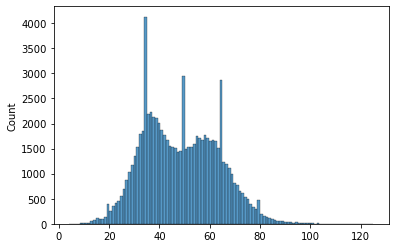

In [6]:
print(f"There are {len(inverted_index_sortpost.documents)} documents")
doc_lenghts=[len(inverted_index_sortpost.raw_freq[ID]) for ID in inverted_index_sortpost.documents]
sb.histplot(doc_lenghts)

In [7]:
round(pd.DataFrame({"doc_lengths": doc_lenghts}).describe(),0)

,doc_lengths
count,79176.0
mean,49.0
std,15.0
min,4.0
25%,37.0
50%,48.0
75%,60.0
max,125.0


### Word raw frequencies

In [8]:
# average number of time each token appears in a document
avg_raw_freqs = [np.mean([inverted_index_sortpost.raw_freq[ID][term] for ID in inverted_index_sortpost.index[term]]) for term in inverted_index_sortpost.index]
round(pd.DataFrame({"avg_raw_freqs":avg_raw_freqs}).describe(),0)

,avg_raw_freqs
count,132161.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,24.0


Most of the terms appear just once in a document.

### Document frequencies

In [9]:
%%time 
doc_freqs=[len(inverted_index_sortpost.index[token]) for token in inverted_index_sortpost.index]
round(pd.DataFrame({"doc_freqs": doc_freqs}).describe(),0)

CPU times: user 94.7 ms, sys: 0 ns, total: 94.7 ms
Wall time: 93.9 ms


,doc_freqs
count,132161.0
mean,29.0
std,571.0
min,1.0
25%,1.0
50%,2.0
75%,5.0
max,73633.0


A term appears on average in 30 $\pm$ 500 documents, 75% of the terms appear in less than 5 documents (a lot of rare terms, weird ??). Lets try to visualize why

In [10]:
for pos , term in enumerate(inverted_index_sortpost.index) : 
    if pos<=500 and len(inverted_index_sortpost.index[term])<=5: print(term) 

stink
relocate
scatter
deters
npr
contributory
fuelsoil
coaltake
circumscribes
apothems
4cm
polygonsproperties
incircle
congruent
equilateral
weisstein
inradius
mathworld
sagitta
hypotenuse


It looks plausible when we look at the above sequence of words (they look rare indeed)

## Preparing for search

In [11]:
tfreqs, idfs, unigram_model=tf(inverted_index_sortpost), idf(inverted_index_sortpost), unigram(inverted_index_sortpost)
# tfreqs, idfs =tf(inverted_index_sortpost), idf(inverted_index_sortpost)

# Searching

## Simple boolean retrieval

In [16]:
searching(index=inverted_index_sortpost, modl='bool', top=3, query_type='AND')

Your query:  what is AIDS ?

Result(s): 
Document(ID=36036, content='What is mean by opportunistic infection-Two examples of opportunistic infections are given below. In day to day life we unknowingly carry out many germs such as, fungi, bacteria, protozoa and viruses. When a person is HIV infection free the immune system resists such invaders. It controls them properly. Examples of Opportunistic Infection. Before going to see the examples of opportunistic infection, it would be better to learn that what is HIV and how it helps such infections to attack on the immune system. HIV is known as Human Immuno Deficiency Virus. The virus leads to develop the AIDS. It attacks on the CD4 cells') 

Document(ID=36038, content='Examples of opportunistic infections are given here for your sake. You can get the list of such examples in the given article. Moreover you would be able to know that what is opportunistic infection and how it leads a person to the life threatening disease that is AIDS. Exa

## Phrase queries retrieval PENDING( POSITIONAL INDEXING TAKES TIME TO RUN DUE TO PREPROCESSING)

In [14]:
# %%time
# query='''the effects of humidity on the mach number and static pressure in the
# working section were investigated and the results are compared with
# theoretical estimates at a nominal mach number 2.0'''
# phrase_retrieval(positional_index_sortpost, query)

## Vector Space Model

In [19]:
searching(index=inverted_index_sortpost, modl='tf_idf',tfreqs= tfreqs, idfs=idfs, top=3)

Your query:  bomb attack

Result(s): 
(Document(ID=34472, content='The history of the atomic bomb began with the Manhattan Project. It was tasked to create the bomb beginning in 1939. The scientists who invented the bomb included Robert Oppenheimer, Edward Teller, Rudolf Peierls and many others.'), 'score = 1.2531907190556753') 

(Document(ID=61695, content='During the attack on Pearl Harbor in Hawaii, the Japanese used war  planes and submarines to bomb the United States Naval Base there.  Many people lost their lives that day. … Some of them were caught on  a ship that sank in the harbor known as the USS Arizona. The attack  happened on December 6, 1941. 1 A Brief Look at the History of Pearl Harbor If you ask anyone about Pearl Harbor, he or she will probably delve into a description of the Japanese attack on it that initiated US involvement in World War II.'), 'score = 1.0908427465168598') 

(Document(ID=34469, content='Atomic Bomb. The atomic bomb was first used in warfare at Hiro

## Binary Independence models

In [20]:
searching(inverted_index_sortpost, modl='bim', top=3)

Your query:  what is franc ?

Result(s): 
(Document(ID=7493, content='[fʁɑ̃] ; sign: F or Fr), also commonly distinguished as the French franc (FF), was a currency of France. Between 1360 and 1641, it was the name of coins worth 1 livre tournois and it remained in common parlance as a term for this amount of money. It was reintroduced (in decimal form) in 1795. It was revalued in 1960, with each new franc (NF) being worth 100 old francs.'), 'score = 3.5975635615929686') 

(Document(ID=77924, content="By the end of the 20th century, the United States dollar was considered the world's most dominant reserve currency, and the world's need for dollars has allowed the United States government as well as Americans to borrow at lower costs, granting them an advantage in excess of $100 billion per year. The Swiss franc, despite gaining ground among the world's foreign-currency reserves and being often used in denominating foreign loans, cannot be considered as a world reserve currency, since th

### Improving with some extensions

In [24]:
searching(inverted_index_sortpost, modl='bim_ext', tfreqs=tfreqs, top=3, extension="two_poisson", k=1.5, b=0.75)

Your query:  what is franc ?

Result(s): 
(Document(ID=7491, content="The currency of France before 2002 was the French Franc. The franc was abolished in 2002 and replaced by the Euro at the rate of €1 = 6.55957 francs. The subdivision of th … e franc was the centime, 1 franc = 100 centimes. The name 'centime' is also used in French for the subdivision of the Euro, €1 = 100 centimes.   France used the franc as its currency up till 2002. Confidence votes 55. The currency used in France is the Euro (symbol €) and its the subdivision is called the 'cent' (English) or 'centime' (French). The Euro replaced the French franc in 2002 at the rate of €1 = 6.55957 francs, and the franc was no longer redeemable after February 201"), 'score = 4.779377065087853') 

(Document(ID=7487, content='French currency conversion. The French Franc is no longer used as money in France, it is now the Euro. The value of the French Franc was fixed at 1 Euro = 6.55957 French Francs, or 1 French Franc = 0.1524490172

In [27]:
searching(inverted_index_sortpost, modl='bim_ext', tfreqs=tfreqs, top=3, extension="bm11", k=1.5, b=0.75)

Your query:  what is franc ?

Result(s): 
(Document(ID=7487, content='French currency conversion. The French Franc is no longer used as money in France, it is now the Euro. The value of the French Franc was fixed at 1 Euro = 6.55957 French Francs, or 1 French Franc = 0.1524490172374104 Euro. '), 'score = 5.597790978394788') 

(Document(ID=7494, content='The franc (₣) is the name of several currency units. The French franc was the former currency of France until the euro was adopted in 1999 (by law, 2002 de facto). The Swiss franc is a major world currency today due to the prominence of Swiss financial institution'), 'score = 5.114119960900326') 

(Document(ID=7491, content="The currency of France before 2002 was the French Franc. The franc was abolished in 2002 and replaced by the Euro at the rate of €1 = 6.55957 francs. The subdivision of th … e franc was the centime, 1 franc = 100 centimes. The name 'centime' is also used in French for the subdivision of the Euro, €1 = 100 centimes. 

In [28]:
searching(inverted_index_sortpost, modl='bim_ext', tfreqs=tfreqs, top=3, extension="bm25", k=1.5, b=0.75)

Your query:  what is franc ?

Result(s): 
(Document(ID=7487, content='French currency conversion. The French Franc is no longer used as money in France, it is now the Euro. The value of the French Franc was fixed at 1 Euro = 6.55957 French Francs, or 1 French Franc = 0.1524490172374104 Euro. '), 'score = 5.20231206592104') 

(Document(ID=7494, content='The franc (₣) is the name of several currency units. The French franc was the former currency of France until the euro was adopted in 1999 (by law, 2002 de facto). The Swiss franc is a major world currency today due to the prominence of Swiss financial institution'), 'score = 4.880572864412698') 

(Document(ID=7491, content="The currency of France before 2002 was the French Franc. The franc was abolished in 2002 and replaced by the Euro at the rate of €1 = 6.55957 francs. The subdivision of th … e franc was the centime, 1 franc = 100 centimes. The name 'centime' is also used in French for the subdivision of the Euro, €1 = 100 centimes.  

## Language model

In [35]:
searching(inverted_index_sortpost, modl='query_lklh', top=5, lang_model=unigram_model)

Your query:  Save the world !!!

Result(s): 
(Document(ID=1, content='We have been feeding our back yard squirrels for the fall and winter and we noticed that a few of them have missing fur. One has a patch missing down his back and under both arms. Also another has some missing on his whole chest. They are all eating and seem to have a good appetite.'), 'score = 0.060670768902718046') 

(Document(ID=2, content='Critters cannot stand the smell of human hair, so sprinkling a barrier of hair clippings around your garden, or lightly working it into the soil when you plant bulbs, apparently does have some merit. The whole thing kind of makes me laugh. It never occurred to me that we are the ones that stink.'), 'score = 0.060670768902718046') 

(Document(ID=3, content="Spread some human hair around your vegetable and flower gardens. This will scare the squirrels away because humans are predators of squirrels. It is better if the hair hasn't been washed so the squirrels will easily pick up t